# MaLSTM on Kaggle's Quora Question Pairs

This notebook is about implementing the MaLSTM model (http://www.mit.edu/~jonasm/info/MuellerThyagarajan_AAAI16.pdf) on Kaggle's Quora Question Pairs data.

Blog post containing a broader explanation about the network can be found in the following link https://medium.com/@eliorcohen/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07


# CODE

First, lets import all the necessary packages

In [17]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Create embedding matrix

In [18]:
EMBEDDING_FILE = '/root/Downloads/GoogleNews-vectors-negative300.bin.gz'

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [19]:
# File paths
TRAIN_CSV = '../mpcnn/train.small.csv'
TEST_CSV = '../mpcnn/test.small.csv'

# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [20]:
from tqdm import tqdm

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
with tqdm(total=len(train_df)+len(test_df)) as pbar:
    for dataset in [train_df, test_df]:
        for index, row in dataset.iterrows():
            pbar.update(1)

            # Iterate through the text of both questions of the row
            for question in questions_cols:

                q2n = []  # q2n -> question numbers representation
                for word in text_to_word_list(row[question]):

                    # Check for unwanted words
                    if word in stops and word not in word2vec.vocab:
                        continue

                    if word not in vocabulary:
                        vocabulary[word] = len(inverse_vocabulary)
                        q2n.append(len(inverse_vocabulary))
                        inverse_vocabulary.append(word)
                    else:
                        q2n.append(vocabulary[word])

                # Replace questions as word to question as number representation
                dataset.set_value(index, question, q2n)

100%|██████████| 99996/99996 [00:18<00:00, 5475.04it/s]


In [21]:
# Iterate over the custom argument components dataset
import pickle
domains=["abortion","gayRights","obama","marijuana"]

sentence_embedding_idx_storage={}

# calculate total sentences
total_sent=0
for domain in domains:
    sentences_storage=pickle.load(open("../../"+domain+".customCorpus.post.sentences.pickle","rb"))
    for post,sentences in sentences_storage.items():
        total_sent+=len(sentences)

# start create word embedding
with tqdm(total=total_sent) as pbar:
    for domain in domains:
        sentence_embedding_idx_storage[domain]={}
        
        # load dataset sentence storage
        sentences_storage=pickle.load(open("../../"+domain+".customCorpus.post.sentences.pickle","rb"))
        for post,sentences in sentences_storage.items():            
            sentence_embedding_idx_storage[domain][post]=[]

            for sentence in sentences:
                pbar.update(1)                
                q2n = []  # q2n -> question numbers representation

                # get sentence vector index representation
                for word in text_to_word_list(sentence):

                    # Check for unwanted words
                    if word in stops and word not in word2vec.vocab:
                        continue

                    if word not in vocabulary:
                        vocabulary[word] = len(inverse_vocabulary)
                        q2n.append(len(inverse_vocabulary))
                        inverse_vocabulary.append(word)
                    else:
                        q2n.append(vocabulary[word])

                # store index representation
                sentence_embedding_idx_storage[domain][post].append(q2n)

100%|██████████| 15181/15181 [00:00<00:00, 22508.56it/s]


In [23]:
# Build the embedding matrix

embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

with tqdm(total=len(vocabulary)) as pbar:
    for word, index in vocabulary.items():
        pbar.update(1)
        if word in word2vec.vocab:
            embeddings[index] = word2vec.word_vec(word)

100%|██████████| 50645/50645 [00:00<00:00, 397853.09it/s]


Prepare training and validation data

In [24]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = int(len(train_df)*0.1)
print(validation_size)
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

4999


Build the model

In [25]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 3072
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 44998 samples, validate on 4999 samples
Epoch 1/25
44998/44998 [==============================] - 11s - loss: 0.2760 - acc: 0.6446 - val_loss: 0.2551 - val_acc: 0.6539
Epoch 2/25
44998/44998 [==============================] - 11s - loss: 0.2436 - acc: 0.6648 - val_loss: 0.2313 - val_acc: 0.6779
Epoch 3/25
44998/44998 [==============================] - 11s - loss: 0.2297 - acc: 0.6825 - val_loss: 0.2247 - val_acc: 0.6863
Epoch 4/25
44998/44998 [==============================] - 11s - loss: 0.2245 - acc: 0.6900 - val_loss: 0.2214 - val_acc: 0.6931
Epoch 5/25
44998/44998 [==============================] - 11s - loss: 0.2215 - acc: 0.6933 - val_loss: 0.2191 - val_acc: 0.6951
Epoch 6/25
44998/44998 [==============================] - 11s - loss: 0.2193 - acc: 0.6958 - val_loss: 0.2172 - val_acc: 0.6963
Epoch 7/25
44998/44998 [==============================] - 11s - loss: 0.2174 - acc: 0.6965 - val_loss: 0.2156 - val_acc: 0.6987
Epoch 8/25
44998/44998 [==============================]

Plotting the results

In [47]:
# predict with custom dataset
import pickle

malstm_result={}

# list total post number
total_post=0
for domain,posts in sentence_embedding_idx_storage.items():
    total_post+=len(posts)

with tqdm(total=total_post) as pbar:
    for domain,posts in sentence_embedding_idx_storage.items():
        malstm_result[domain]={}
        for post,sentences in posts.items():
            pbar.update(1)
            
            malstm_result[domain][post]=[]
            for ai,a in enumerate(sentences):
                row=[]
                for bi,b in enumerate(sentences):
                    instance=[pad_sequences(np.array([a]), maxlen=max_seq_length),pad_sequences(np.array([b]), maxlen=max_seq_length)]
                    scores=malstm.predict(instance)
    #                 print(scores)
                    row.append(scores)
                    pass
                pass
                malstm_result[domain][post].append(row)

# dump storage
pickle.dump(malstm_result,open("../malstm.dataset.similarity.pickle","wb"))

  0%|          | 2/1901 [00:00<08:59,  3.52it/s]


KeyboardInterrupt: 

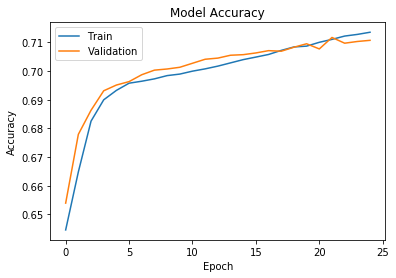

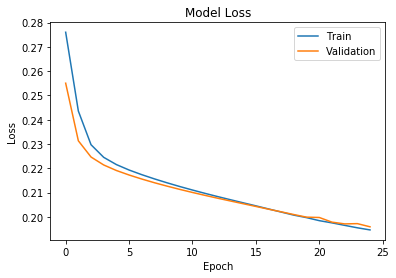

In [27]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()